In [50]:
import pandas as pd
import numpy as np
import io
import os
import re
import sys
from pandasql import sqldf
from sklearn.model_selection import train_test_split
from scipy.sparse import coo_matrix
import jieba
import json
root_path = 'C:\\Users\\luoyan011\\Desktop\\PersonalLearning\\GitHub\\NLP_data\\chinese_recommender'
sys.path.append('C:\\Users\\luoyan011\\Desktop\\PersonalLearning\\GitHub\\python_functions\\jl_nlp_pkg')
stop_words_path = 'C:\\Users\\luoyan011\\Desktop\\PersonalLearning\\GitHub\\NLP\\recomend_system\\Chinese\\hit_stopwords.txt'

sys.path.append('C:\\Users\\luoyan011\\Desktop\\PersonalLearning\\GitHub\\python_functions\\jl_nlp_pkg')
import nlpbasic.dataExploration as DataExploration


In [3]:
weibo_data = dfs = pd.read_excel(os.path.join(root_path, "Weibo_2020Coron.xlsx"),sheet_name='results')
weibo_data['index'] = weibo_data.index
weibo_data.head(3)

,Unnamed: 0,Unnamed: 1,title_translate,title,searchCount,"Coron-Related ( 1 yes, 0 not )",index
0,2020-01-01 08:24:01,2019-12-31 20:54:02,Chaired Xie Na,谢娜的主持,3368333.0,NaN,0
1,2020-01-01 00:52:01,2019-12-31 16:46:01,New Year's Eve,跨年,2599465.0,NaN,1
2,2020-01-01 08:34:02,2019-12-31 22:22:02,A too Yiyangqianxi the,易烊千玺太A了,2000970.0,NaN,2


In [4]:
print('start read stopwords data.')
stopwords = []
with open(stop_words_path, 'r', encoding='utf-8') as f:
    for line in f:
        if len(line)>0:
            stopwords.append(line.strip())
print(stopwords)

start read stopwords data.
['———', '》），', '）÷（１－', '”，', '）、', '＝（', ':', '→', '℃', '&', '*', '一一', '~~~~', '’', '.', '『', '.一', './', '--', '』', '＝″', '【', '［＊］', '｝＞', '［⑤］］', '［①Ｄ］', 'ｃ］', 'ｎｇ昉', '＊', '//', '［', '］', '［②ｅ］', '［②ｇ］', '＝｛', '}', '，也', '‘', 'Ａ', '［①⑥］', '［②Ｂ］', '［①ａ］', '［④ａ］', '［①③］', '［③ｈ］', '③］', '１．', '－－', '［②ｂ］', '’‘', '×××', '［①⑧］', '０：２', '＝［', '［⑤ｂ］', '［②ｃ］', '［④ｂ］', '［②③］', '［③ａ］', '［④ｃ］', '［①⑤］', '［①⑦］', '［①ｇ］', '∈［', '［①⑨］', '［①④］', '［①ｃ］', '［②ｆ］', '［②⑧］', '［②①］', '［①Ｃ］', '［③ｃ］', '［③ｇ］', '［②⑤］', '［②②］', '一.', '［①ｈ］', '.数', '［］', '［①Ｂ］', '数/', '［①ｉ］', '［③ｅ］', '［①①］', '［④ｄ］', '［④ｅ］', '［③ｂ］', '［⑤ａ］', '［①Ａ］', '［②⑧］', '［②⑦］', '［①ｄ］', '［②ｊ］', '〕〔', '］［', '://', '′∈', '［②④', '［⑤ｅ］', '１２％', 'ｂ］', '...', '...................', '…………………………………………………③', 'ＺＸＦＩＴＬ', '［③Ｆ］', '」', '［①ｏ］', '］∧′＝［', '∪φ∈', '′｜', '｛－', '②ｃ', '｝', '［③①］', 'Ｒ．Ｌ．', '［①Ｅ］', 'Ψ', '－［＊］－', '↑', '.日', '［②ｄ］', '［②', '［②⑦］', '［②②］', '［③ｅ］', '［①ｉ］', '［①Ｂ］', '［①ｈ］', '［①ｄ］', '［①ｇ］', '［①②］', '［②ａ］', 'ｆ］', '

In [38]:
def preprocess_text(text):
    try:
        segs=jieba.lcut(text)
        segs = filter(lambda x:len(x)>1, segs)
        segs = [v for v in segs if not str(v).isdigit()]#去数字
        segs = list(filter(lambda x:x.strip(), segs)) #去左右空格
        segs = filter(lambda x:x not in stopwords, segs)
        temp = " ".join(segs)
        return(temp)
    except Exception:
        pass

In [64]:
weibo_data['tokenizer'] = weibo_data['title'].apply(lambda x: preprocess_text(x))
weibo_data.columns = ['date1', 'date2', 'title_translate', 'title', 'searchCount', 'coron', 'index', 'tokenizer']
weibo_data.head(3)

,date1,date2,title_translate,title,searchCount,coron,index,tokenizer
0,2020-01-01 08:24:01,2019-12-31 20:54:02,Chaired Xie Na,谢娜的主持,3368333.0,NaN,0,谢娜 主持
1,2020-01-01 00:52:01,2019-12-31 16:46:01,New Year's Eve,跨年,2599465.0,NaN,1,跨年
2,2020-01-01 08:34:02,2019-12-31 22:22:02,A too Yiyangqianxi the,易烊千玺太A了,2000970.0,NaN,2,千玺


In [47]:
document = list(weibo_data.tokenizer.dropna())
document[0:3]

['谢娜 主持', '跨年', '千玺']

In [48]:
def getWordDict(document, data_path, min_count=5):
    """
    功能：构建单词词典
    """
    word2id = {}
    # 统计词频
    for word in sum([a_tuple.split(' ') for a_tuple in document],[]):
        if word2id.get(word) == None:
            word2id[word] = 1
        else:
            word2id[word] += 1
            
    # 过滤低频词
    vocab = set()
    for word,count in word2id.items():
        if count >= min_count:
            vocab.add(word)

    # 构成单词到索引的映射词典
    word2id = {"PAD":0,"UNK":1}
    length = 2
    for word in vocab:
        word2id[word] = length
        length += 1
    with open(os.path.join(data_path, "word2id.json"),'w',encoding="utf-8") as fp:
        json.dump(word2id,fp,ensure_ascii=False)


In [51]:
getWordDict(document, root_path, min_count=2)

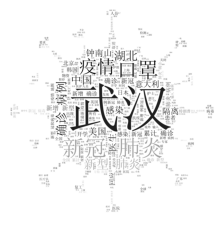

In [84]:
# get word cloud plot
from numpy import array, concatenate, atleast_1d
pandemic_weibo = list(weibo_data[weibo_data.coron==1]['tokenizer'])
all_tokens = concatenate([atleast_1d(a) for a in pandemic_weibo])
all_tokens = " ".join(all_tokens)
img_link = os.path.join(root_path, 'virus.png')
font_path = "C:\\Users\\luoyan011\\Desktop\\PersonalLearning\\GitHub\\NLP\\recomend_system\\Chinese\\simsun.ttf"
DataExploration.generate_chinese_word_cloud(all_tokens, img_link, font_path ,stopwords = '', color_control = True, save = True)


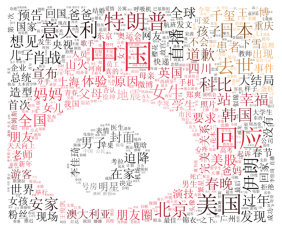

In [88]:
# get word cloud plot
from numpy import array, concatenate, atleast_1d
pandemic_weibo = list(weibo_data[weibo_data.coron!=1]['tokenizer'].dropna())
all_tokens = concatenate([atleast_1d(a) for a in pandemic_weibo])
all_tokens = " ".join(all_tokens)
img_link = os.path.join(root_path, 'weibo.png')
font_path = "C:\\Users\\luoyan011\\Desktop\\PersonalLearning\\GitHub\\NLP\\recomend_system\\Chinese\\simsun.ttf"
DataExploration.generate_chinese_word_cloud(all_tokens, img_link, font_path ,stopwords = '', color_control = True, save = True)
